In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid2562903/


In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import pyccl as ccl
import pymaster as nmt
import healpy as hp

import sys
sys.path.insert(0, '../skylens')
import correction

%load_ext autoreload
%autoreload 2

In [3]:
cl_theory = {
    i: np.loadtxt(f'../data/cl_{i}_{i}.txt')[1] for i in range(4)
}

In [4]:
with open('../data/bu.pickle', 'rb') as f:
    bu = pickle.load(f)
    
with open('../data/M.pickle', 'rb') as f:
    SL = pickle.load(f)

In [5]:
nside = 1024
ell = np.arange(3*nside)

In [6]:
#setup parameters
lmax_cl = 2200 #2000
lmin_cl = 0

l0 = np.arange(lmin_cl, lmax_cl)

window_lmax = lmax_cl

lmin_cl_Bins = 200 #lmin_cl+2
lmax_cl_Bins = lmax_cl - 10
Nl_bins = 16

#l_bins = np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins), np.log10(lmax_cl_Bins), Nl_bins+1)))
#l_bins = np.arange(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
l_bins = np.linspace(lmin_cl_Bins, lmax_cl_Bins, Nl_bins)
lb = .5 * (l_bins[1:] + l_bins[:-1])
dl = (l_bins[1:] - l_bins[:-1])
lb_cl = lb * 1.
l_bins_center = lb * 1.
Nl_bins = len(lb)

l = l0

In [7]:
sigma_e = 0.25
arcmin2rad = 1 / 60 * (np.pi / 180)
n_source = 12 
noise_cl = sigma_e ** 2 / n_source * arcmin2rad ** 2
noise_cl = noise_cl * np.ones_like(cl_theory[0])

In [8]:
pcl_t = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_with_noise.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_t[i][b] = d[b][1]
        
pcl_noise = np.zeros((100, 4, 3*nside))
for i in range(100):
    fname = f'../sims/pcl_{i}_noise.pickle'
    with open(fname, 'rb') as f:
         d = pickle.load(f)
    for b in range(4):
        pcl_noise[i][b] = d[b][1]

In [9]:
def bin_2d_coupling(
        M=[],
        bin_utils=None,
        wt_b=None,
        wt0=None,
        partial_bin_side=None,
        lm=0,
        lm_step=-1,
        cov=False,
    ):  # asymmetric binning
        ndim = 1
        if cov:
            ndim = 2
        binning_mat = bin_utils["binning_mat"]

        if len(wt0.shape) == 1:
            binning_mat2 = wt0[:, None] * binning_mat * wt_b
        else:
            binning_mat2 = (
                wt0 @ binning_mat @ wt_b
            )  # FIXME: Test this.... doesnot work. not used anymore.

        #         rdr=bin_utils['r_dr']
        #         r_dr_m=bin_utils['r_dr_m'][ndim]
        #         binning_mat=binning_mat*rdr[:,None]/bin_utils['norm'][None,:]

        binning_mat = bin_utils["binning_mat_r_dr"]
        if partial_bin_side is None:
            cov_b = binning_mat.T @ M @ binning_mat2
        elif partial_bin_side == 1:
            cov_b = binning_mat.T @ M @ binning_mat2[lm : lm + lm_step, :]
        elif partial_bin_side == 2:
            cov_b = binning_mat[lm : lm + lm_step, :].T @ M @ binning_mat2

        #         cov_b/=bin_utils['norm_m'][1][:,None]
        return cov_b

    
def bin_1d(xi=[], bin_utils=None):
    xi_b = jnp.dot(xi * bin_utils["r_dr"], bin_utils["binning_mat"])
    xi_b /= bin_utils["norm"]
    return xi_b

In [10]:
cl_sl_binned = dict()
cl_theory_binned = dict()

for n in range(100):
    cl_sl_binned[n] = dict()
    for i in range(4):
        bi = (i, i)
        M = SL[bi]['M']
        M_noise = SL[bi]['M_noise']
        pcl_n = noise_cl[:lmax_cl] @ M_noise
        pcl = pcl_t[n][i][:lmax_cl] - pcl_n
        pcl_binned = bin_1d(pcl, bin_utils=bu)
        cl_binned = bin_1d(cl_theory[i][:lmax_cl], bin_utils=bu)

        cl_theory_binned[i] = cl_binned

        wt0 = 1. / cl_theory[i][:lmax_cl]
        wt0[0] = 0

        M_binned = bin_2d_coupling(M=M, bin_utils=bu, wt_b=cl_binned, wt0=wt0)

        cl_sl_binned[n][i] = pcl_binned @ np.linalg.pinv(M_binned) 

/tmp/ipykernel_2562903/4238567450.py:17: RuntimeWarning: divide by zero encountered in true_divide
  wt0 = 1. / cl_theory[i][:lmax_cl]


In [11]:
cl_sl_t_binned = np.zeros((100, 4, Nl_bins))
for i in range(100):
    for b in range(4):
        cl_sl_t_binned[i][b] = cl_sl_binned[i][b]

In [12]:
cl_sl_binned_mean = np.median(cl_sl_t_binned, axis=0)
cl_sl_binned_std = np.std(cl_sl_t_binned, axis=0)

<Figure size 2160x864 with 0 Axes>

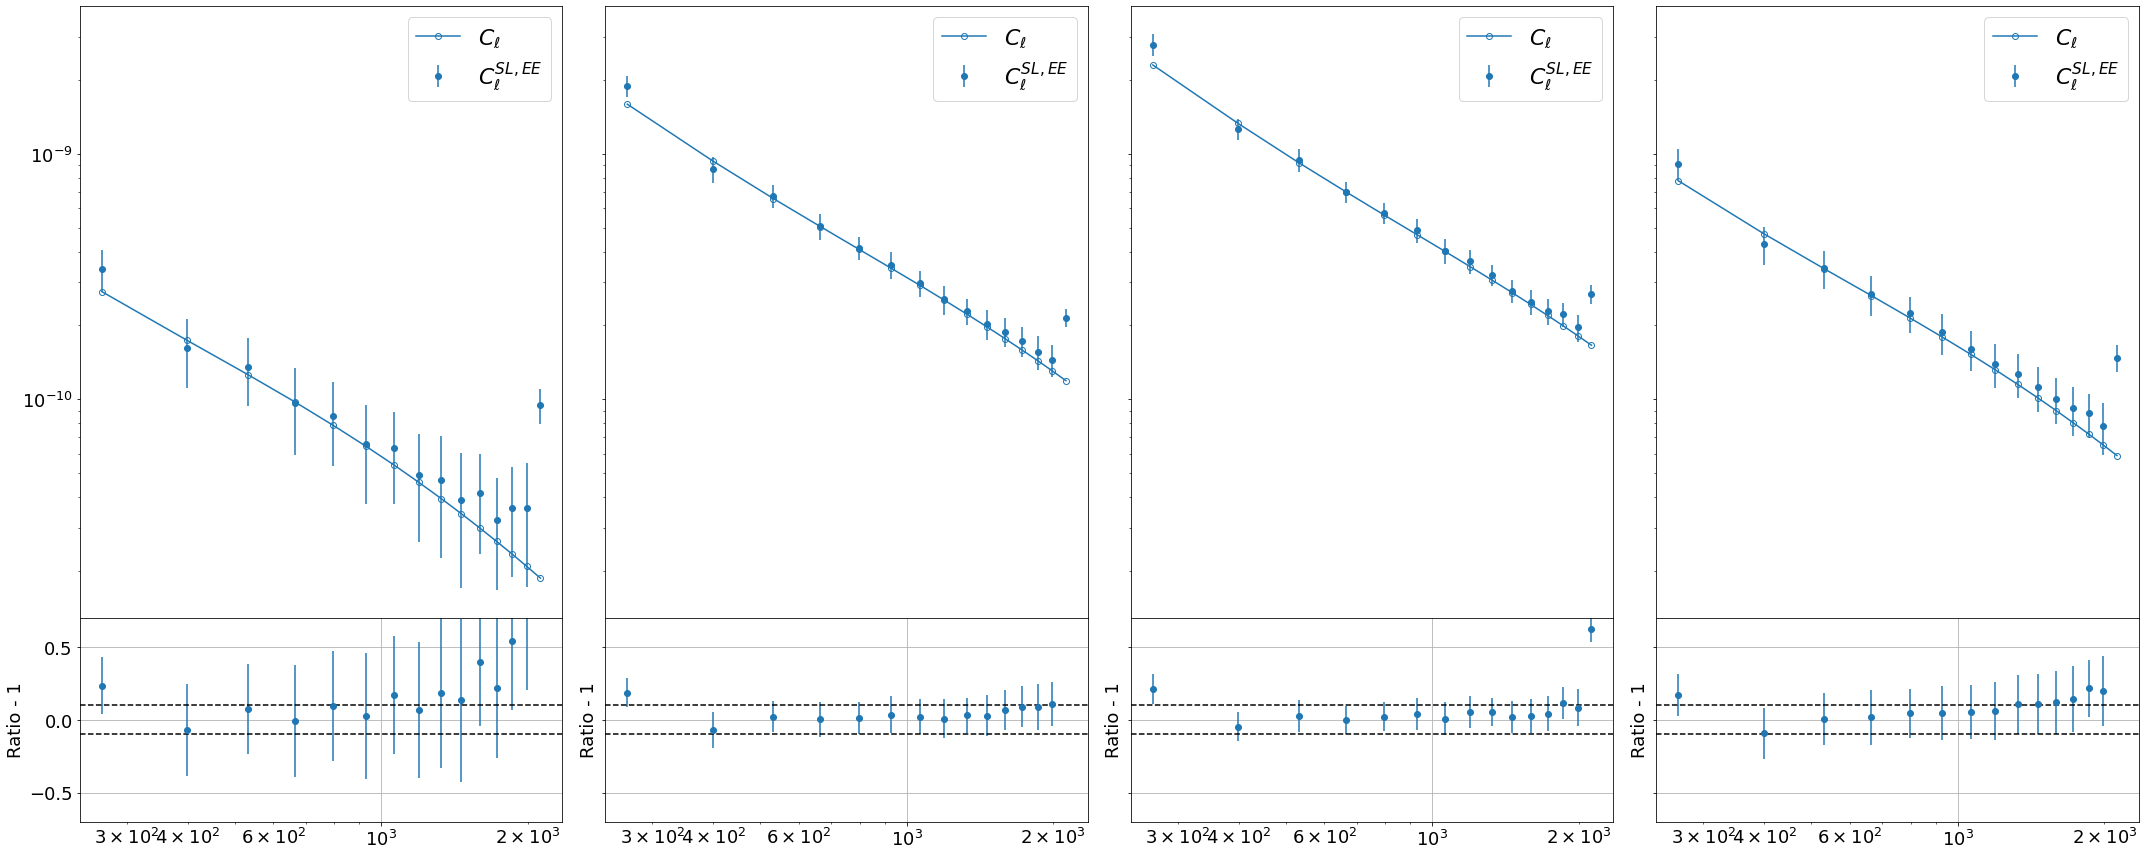

In [13]:
bc = 0.5 * (l_bins[1:] + l_bins[:-1])
fig = plt.figure(figsize=(30, 12))
fig, axs = plt.subplots(nrows=2, ncols=4, sharey='row', sharex=True,
                       gridspec_kw={'height_ratios': [3, 1], 'hspace': 0},
                       figsize=(30, 12))
for i in range(4):
    ax0, ax1 = axs[0, i], axs[1, i]
    ax0.errorbar(bc, cl_sl_binned_mean[i], cl_sl_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{SL, EE}$', c='C0')
    #ax0.errorbar(bc, pcl_bb_binned_mean[i], cv_bb[i], fmt='o', ls='None', label=r'$C_\ell^{SL, BB}$', c='C1')
    ax0.loglog(bc, cl_theory_binned[i], 'o', ls='-', label=r'$C_\ell$', c='C0', fillstyle='none')
    #ax0.errorbar(bc, pcl_t_bb_binned[0][i], pcl_bb_binned_std[i], fmt='o', ls='None', label=r'$C_\ell^{BB, SL}$', c='green')
    #ax0.loglog(bc, pcl_bb_binned_mean[i], 'v', label=r'$C_\ell^{BB, SL}$', c='green')
    #ax0.loglog(bc, cl_bb_binned[i], 'o', ls='-', label=r'$C_\ell^{BB}$', c='green', fillstyle='none')
    ax0.tick_params(axis='both', which='major', labelsize=18)
    ax0.tick_params(axis='both', which='minor', labelsize=18)
    ax0.label_outer()
    ax0.legend(fontsize=22)
    
    #ax1.semilogx(bc, pcl_bb_binned_mean[i] / cl_bb_binned[i] - 1, 'o', label='BB', c='green')
    #ax1.semilogx(bc, pcl_ee_binned_mean[i] / cl_ee_binned[i] - 1, 'v', label='EE', c='red')
    ax1.errorbar(bc, cl_sl_binned_mean[i] / cl_theory_binned[i] - 1, cl_sl_binned_std[i] / cl_sl_binned_mean[i], fmt='o', c='C0')
    #ax1.errorbar(bc, pcl_t_bb_binned[0][i] / cl_bb_binned[i] - 1, pcl_bb_binned_std[i] / pcl_t_bb_binned[0][i], fmt='o', c='green')
    ax1.set_xscale('log')
    ax1.grid(True)
    ax1.set_ylim(-0.7, 0.7)
    ax1.axhline(0.1, c='black', ls='--')
    ax1.axhline(-0.1, c='black', ls='--')
    ax1.set_ylabel('Ratio - 1', fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.tick_params(axis='both', which='minor', labelsize=18)
    #ax1.legend()
plt.tight_layout()